In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from tqdm.auto import tqdm

In [128]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(20,7)}
)

In [88]:
active_studs = pd.read_csv('C:/Users/User/projects_python/FINAL_PROJ/Проект_2_active_studs.csv',sep=';')
checks = pd.read_csv('C:/Users/User/projects_python/FINAL_PROJ/Проект_2_checks.csv',sep=';')
groups_add = pd.read_csv('C:/Users/User/projects_python/FINAL_PROJ/Проект_2_group_add.csv',sep=',')
groups = pd.read_csv('C:/Users/User/projects_python/FINAL_PROJ/Проект_2_groups.csv',sep=';')

# Смотрим на изначальные данные без дополнительных пользователей

## Уберём пользователей, не сделавших покупки

In [114]:
students_without_groups = active_studs.join(checks.set_index('student_id'),on='student_id',how='left').dropna()

In [117]:
students_with_groups = students_without_groups.join(groups,how='left')

### Проверяем распределение доходов с пользователей на нормальность, ожидаемо получаем, что распределение не является нормальным:

In [127]:
stats.shapiro(students_with_groups.rev)

ShapiroResult(statistic=0.8714179396629333, pvalue=1.6449447664488742e-17)

### Визуализируем для наглядности

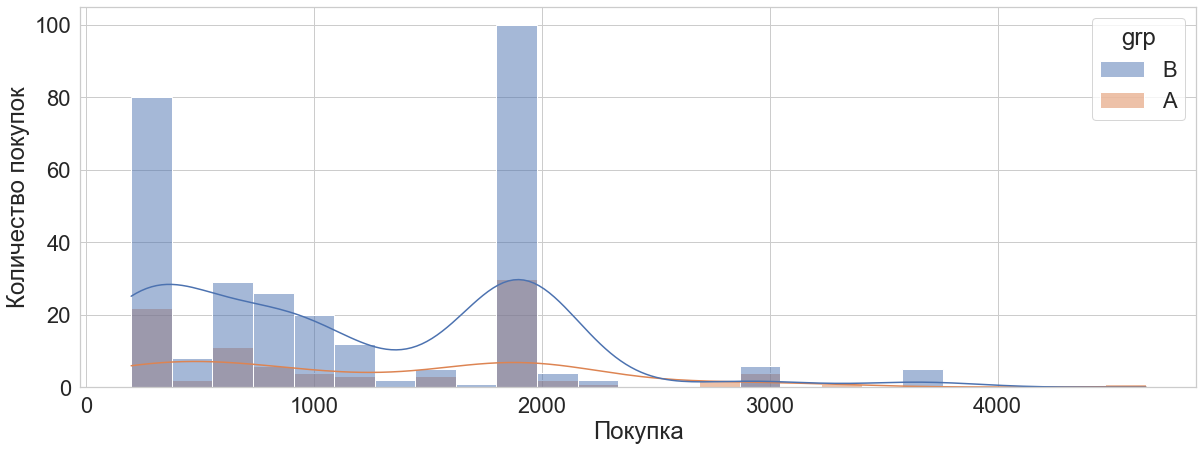

In [144]:
sns.histplot(x=students_with_groups.rev,hue = students_with_groups.grp,kde = True,bins=25)
plt.xlabel('Покупка')
plt.ylabel('Количество покупок');

### Посмотрим ARPPU по группе

In [154]:
round(students_with_groups[students_with_groups['grp'] == 'A'].rev.mean(),1)

1294.6

In [149]:
students_with_groups[students_with_groups['grp'] == 'A'].rev.quantile()

1140.0

In [153]:
round(students_with_groups[students_with_groups['grp'] == 'B'].rev.mean(),1)

1162.3

In [150]:
students_with_groups[students_with_groups['grp'] == 'B'].rev.quantile()

990.0

### Применим U-тест к выборкам , положим a=0.05

In [164]:
stats.mannwhitneyu(students_with_groups[students_with_groups['grp'] == 'A'].rev, 
                   students_with_groups[students_with_groups['grp'] == 'B'].rev)

MannwhitneyuResult(statistic=14899.0, pvalue=0.24293906646890728)

### U-тест показывает, что различия между выборками незначимы

## Проведём бутстрап тест:

### Функция для бутстрат-теста:

In [175]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

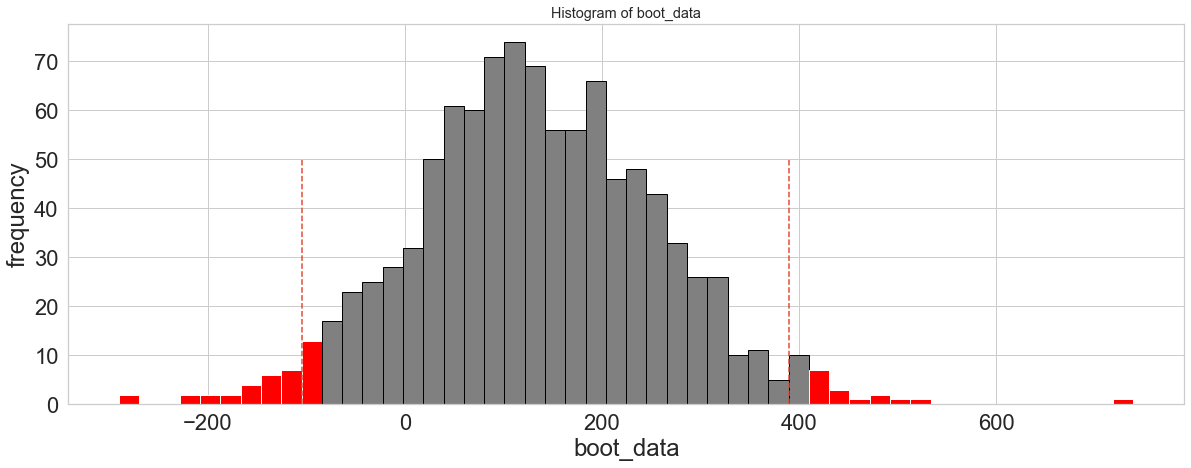

In [176]:
booted_data = get_bootstrap(students_with_groups.query('grp == "A"').rev, 
                            students_with_groups.query('grp == "B"').rev)

## Бутстрап и Манна-Уитни показали примерно одни и те же результаты => значимых различий между выборками нет

In [177]:
booted_data["p_value"]

0.2849018591952721

# Смотрим на данные через 2 дня

In [187]:
add_rev = checks.join(groups_add,how='inner')

In [198]:
add_rev.head()

,student_id,rev,id,grp
0,1627,990.0,5694584,B
1,3185,690.0,5694830,B
2,25973,690.0,5695057,B
3,26280,690.0,5698872,B
4,100300,990.0,5699067,B


### Распределение не является нормальным:

In [190]:
stats.shapiro(add_rev.rev)

ShapiroResult(statistic=0.6943658590316772, pvalue=1.5251902388616068e-12)

### Применим U-тест к выборкам , положим a=0.05

In [192]:
stats.mannwhitneyu(add_rev[add_rev['grp'] == 'A']['rev'],add_rev[add_rev['grp'] == 'B']['rev'])

MannwhitneyuResult(statistic=810.0, pvalue=0.6852364373412241)

### Бустрап:

  0%|          | 0/1000 [00:00<?, ?it/s]

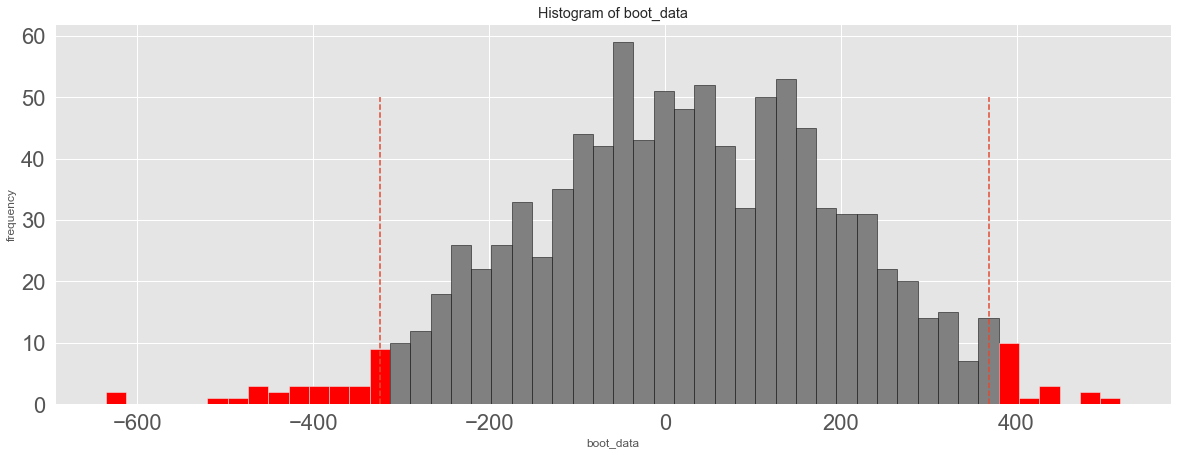

In [194]:
booted_data2 = get_bootstrap(add_rev[add_rev['grp'] == 'A']['rev'],
                             add_rev[add_rev['grp'] == 'B']['rev'])

In [195]:
booted_data2['p_value']

0.9043674912176849

### Бустрап не позволяет отклонить нулевую гипотезу

# Объеденим все данные, получим:

In [203]:
union_data = pd.concat([add_rev, students_with_groups], ignore_index=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

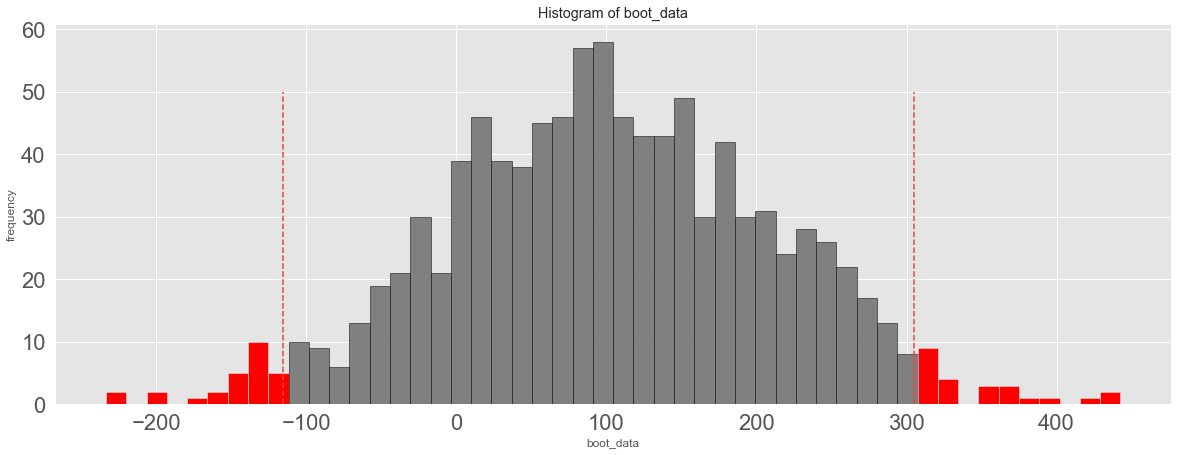

0.3462901766818224

In [208]:
get_bootstrap(union_data[union_data['grp'] == 'A']['rev'],union_data[union_data['grp'] == 'B']['rev'])['p_value']

# Теперь проверим ARPU со всеми данными, т.е доход от пользователей , которые не сделали покупку будет равен 0.

In [233]:
studs_zero = active_studs.join(checks.set_index('student_id'),on='student_id',how='left')

In [234]:
studs_zero = studs_zero.join(groups,how='left')

In [235]:
studs_zero = studs_zero.fillna(0)

## До новых данных:

  0%|          | 0/1000 [00:00<?, ?it/s]

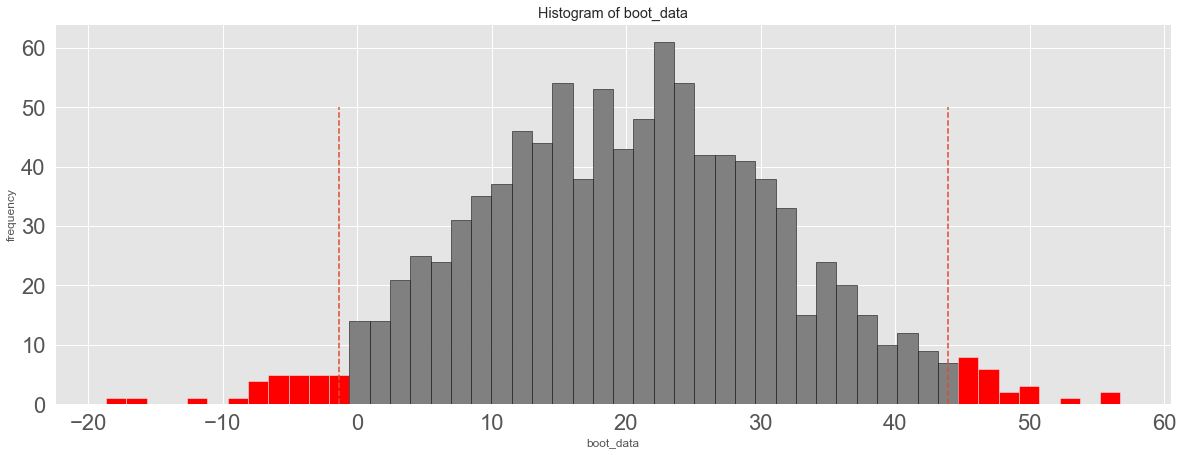

0.07988302492368599

In [245]:
get_bootstrap(studs_zero.query('grp == "A"').rev,studs_zero.query('grp == "B"').rev)['p_value']

In [237]:
full_data_with0 = pd.concat([add_rev, studs_zero], ignore_index=True)

In [250]:
full_data_with0.shape

(8433, 4)

## C новыми данными:

  0%|          | 0/1000 [00:00<?, ?it/s]

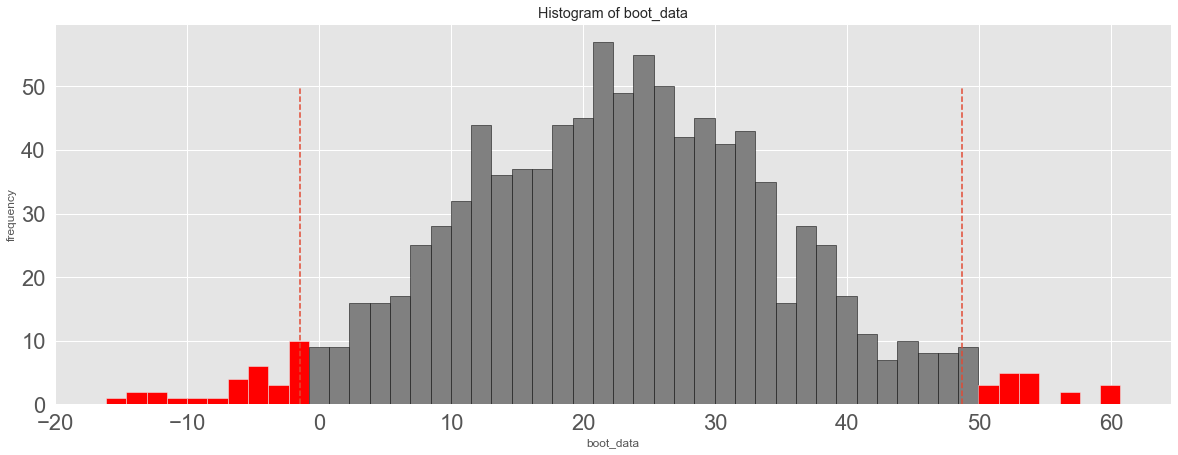

0.06927585184066386

In [248]:
get_bootstrap(full_data_with0.query('grp == "A"').rev,full_data_with0.query('grp == "B"').rev)['p_value']

## Проверка ARPU также не привела к положительному результату

# Вывод : на основании А/Б теста мы не можем принять решение о добавлении новой функции оплаты на сайте